In [7]:
import sys
import os
import json

if '..//..//' not in sys.path:
    sys.path.append('..//../')

from opmsim.optical_system_base import OpticalSystem
from opmsim import optical_elements
from opmsim import dipole_source
import numpy as np
from matplotlib import pyplot as plt


## Element setup and save paths

In [14]:
savepath = "C:/Users/lnr19/OneDrive - Imperial College London/thesis/for _thesis/modelling/pupils_2/"
#savepath = "C:/Users/Leo/OneDrive - Imperial College London/thesis/for _thesis/modelling/pupils_2/"


savepath_full = os.path.join(savepath, "OPM_nico_highNA_test")
if not os.path.exists(savepath_full):
    os.makedirs(savepath_full)
save_filename = os.path.join(savepath_full,'collection_efficiency_uni.txt')
save_details = os.path.join(savepath_full,'sim_details.txt')


# setup
# O1
M_O1 = 60
NA_O1 = 1.2
n_O1 =1.33
f_TL1 = 0.180  # Olympus
f_O1 = f_TL1/M_O1

# high NA O1 (Nikon)
M_O1_h = 60
NA_O1_h = 1.27
n_O1_h = 1.33
f_TL1_h = 0.20  # Nikon
# f_TL1_h = 0.18  # Using original Olympus TL, then use 162mm TL2 if using Thorlabs O2!

f_O1_h = 0.2/M_O1

# long WD (O3 or O2)
M_LWD = 50
NA_LWD = 0.75
f_LWD = 0.2/M_LWD

# O2
M_olympus_50x = 50
NA_olympus_50x = 0.95
f_olympus_50x = 0.180/M_olympus_50x

f_TL2 = 0.162406015
# f_TL2= 0.162#0.180  # Olympus
f_TL2_flipped = 0.180451128 #0.180# 0.150376
f_TL2_lwd = 0.180
# f_TL2_flipped = 0.180451128

# f_TL2_flipped = 0.162# 0.150376

# O3 (original)
M_O3 = 40
NA_O3 = 0.6
n_O3 = 1
f_TL3 = 0.1013  
f_O3 = 0.2/M_O3 # Nikon

# include extra angles
include_extra_angles = False; #True

opm_angles = [0, 35, 45]#,18.2, 23.2]
opm_angles = [0]


In [17]:
dipole_count = 7500

options = {
    'ray_count': 15000,
    'draw_rays': False,
    'max_rays_stored': 10000,
    'ray_dist': 'uniform'
}

# 'ray_dist': 'uniform_phi_inbetween'
# 'ray_dist': 'fibonacci'

plot_options = {
    'title': 'Pupil intensity at final image plane of dOPM microscope',
    'add_sim_details': True,
    'max_r_in': 0,
    'scale_range': None,# [0,0.3],
    'add_autoscale_plots': True
}

#opm_angle = 35*np.pi/180

O1 = optical_elements.SineLens(NA=NA_O1, focal_length=f_O1, n=n_O1)
O1_h = optical_elements.SineLens(NA=NA_O1_h, focal_length=f_O1_h, n=n_O1_h)
TL1 = optical_elements.SineLens(NA=0.1, focal_length=f_TL1, n=1)
TL1_h = optical_elements.SineLens(NA=0.1, focal_length=f_TL1_h, n=1)
olympus_50x_angled = lambda opm_angle: optical_elements.SineLens(NA=NA_olympus_50x, focal_length=f_olympus_50x, n=1, yAxis_rotation=opm_angle*np.pi/180)
olympus_50x = optical_elements.SineLens(NA=NA_olympus_50x, focal_length=f_olympus_50x, n=1)
TL2 = optical_elements.SineLens(NA=0.1, focal_length=f_TL2, n=1)
TL2_flipped = optical_elements.SineLens(NA=0.1, focal_length=f_TL2_flipped, n=1)
TL2_lwd = optical_elements.SineLens(NA=0.1, focal_length=f_TL2_lwd, n=1)
LWD = optical_elements.SineLens(NA=NA_LWD, focal_length=f_LWD, n=1)
LWD_angled = lambda opm_angle: optical_elements.SineLens(NA=NA_LWD, focal_length=f_LWD, n=1, yAxis_rotation=opm_angle*np.pi/180)
TL3 = optical_elements.SineLens(NA=0.1, focal_length=f_TL3, n=1)
O3 = lambda opm_angle: optical_elements.SineLens(NA=NA_O3, focal_length=f_O3, n=1, yAxis_rotation=opm_angle*np.pi/180)

elements_fun = lambda opm_angle: [O1_h, TL1_h, TL2, olympus_50x, LWD_angled(opm_angle)]
#elements_fun = lambda opm_angle: [O1, TL1, TL2, olympus_50x, LWD_angled(opm_angle)]

# elements_fun = lambda opm_angle: [O1, TL1, TL2_lwd, LWD]

# elements_fun = lambda opm_angle: [O1_h, TL1_h, TL2_flipped, LWD, olympus_50x_angled(opm_angle)]
elements_test = elements_fun(0)

# Check magnification is correct
M1 = elements_test[1].focal_length/elements_test[0].focal_length
M2 = elements_test[2].focal_length/elements_test[3].focal_length
Mt = M1/M2

if abs(Mt-elements_test[0].n)>5e-3:
    print("Focal lengths: %f %f %f %f" % (elements_test[0].focal_length, elements_test[1].focal_length, elements_test[2].focal_length, elements_test[3].focal_length))
    raise ValueError("Refocusing system magnification is not correct: %f not %f" % (Mt, elements_test[0].n))

# add extra angles
NA_lim = min(elements_test[0].NA/elements_test[0].n, elements_test[3].NA/elements_test[3].n)
theta_minO1O2 = 180*np.arcsin(NA_lim)/np.pi
min_OPM_angle = 90-theta_minO1O2
theta3 = 180*np.arcsin(elements_test[4].NA/elements_test[4].n) / np.pi
OPM_angle_noclip = (theta_minO1O2-theta3)*((theta_minO1O2-theta3)>0)

if include_extra_angles and (min_OPM_angle not in opm_angles) and (min_OPM_angle not in opm_angles): 
    if min_OPM_angle not in opm_angles: 
        opm_angles.append(min_OPM_angle)
    if OPM_angle_noclip not in opm_angles: 
        opm_angles.append(OPM_angle_noclip)

print("OPM angles:", opm_angles)    
        
s_pol = lambda opm_angle: (0, (90-opm_angle)*np.pi/180)
p_pol = (np.pi/2,0)

plot_options_p = plot_options; plot_options_s = plot_options; plot_options_un = plot_options;
plot_options_p['scale_range'] = [0,3,4]
plot_options_s['scale_range'] = [0,3,4]
plot_options_un['scale_range'] = [0,7,5]

OPM angles: [0]


Full sphere generation
cap method area sum 12.564694874875116
expected area sum 6.283185307179586
cap method area sum 4.417276005564659
expected area sum 4.4172760189146585


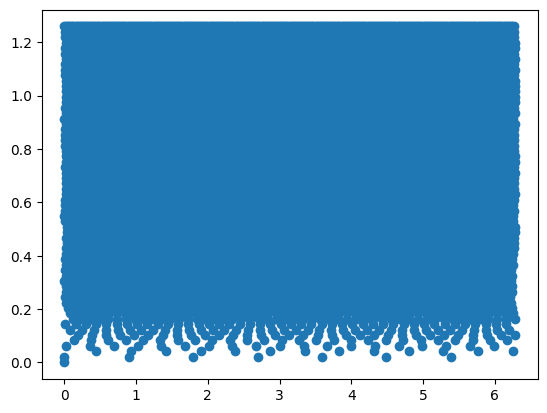

n_dipoles 7499
n_rays 10751
pvec shape (7499, 1, 3)
nvec shape (1, 10751, 3)
(7499, 10751, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
cap method area sum 6.283185293923816
expected area sum 6.283185307179586
n_dipoles 7499
n_rays 15308
pvec shape (7499, 1, 3)
nvec shape (1, 15308, 3)
(7499, 15308, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
n rays 2pi =  15308
(10751, 3, 1)
n rays =  10751
NA area vs real area? 4.417276005564659 4.4172760189146585
half_sphere_energy 4.188790621855782
initial_energy 2.9448872423105437
rays when NA scaled up to hemisphere 15292.348758010825
initialisation time in system 31.986387s
Flat pupil
ELEMENT: <opmsim.optical_elements.SineLens object at 0x000002298D550820>
CURVED REFRACTION
max rho curved 0.003172725174692312
ELEMENT: <opmsim.optical_elements.SineLens object at 0x00000229E39214F0>
max rho flat 0.004219724482340775
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000022986CFD610>
CURVED REFRACTION
max rho curved 0.0
ELEM

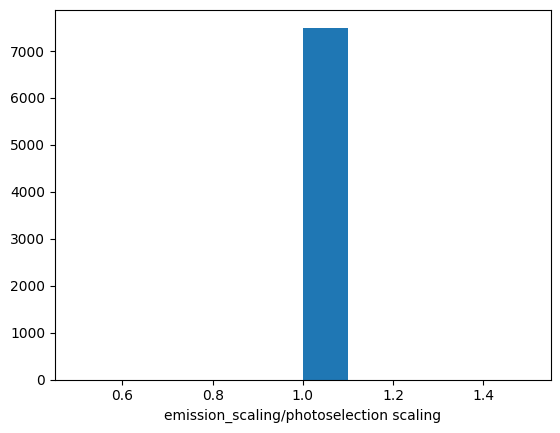

Limiting radius for detector: 0.004233333333333334
Energy ratio (efficiency): 0.47726898054480377
Total energy per dipole per ray: 1.4055033319569517
Energy from Ix 1710.394177637266
Energy from Iy 1710.3941776372662
X/Y energy ratio = 0.9999999999999999
Half sphere energy 4.188790621855782
Initial energy 2.9448872423105437
half sphere energy NA 2.9448509698020953
maxr 0.004233333333333334
5620 escaped out of 10751
Saved checkpoint with 10000 rays
5620 escaped out of 10751
time in trace_rays 64.657627s
ray count 5131
max Ix 4.956074215749714
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.0029599435864074482
max_r_reduced 0.002959912567765138 max_r 0.0029599435864074482


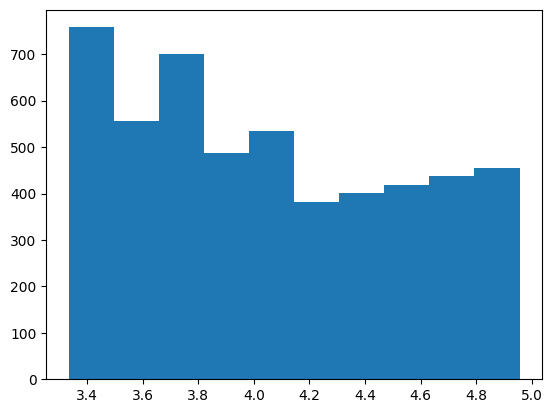

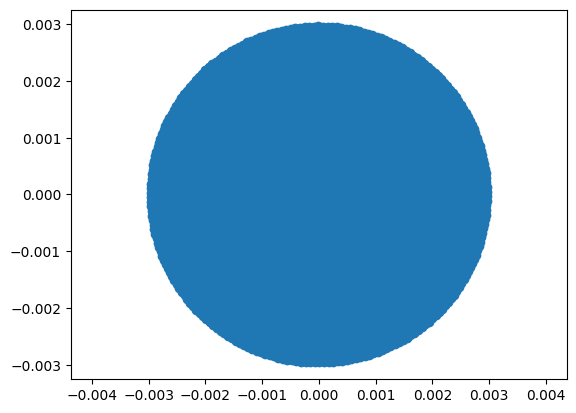

max_r_in None max_r 0.0029599435864074482
cb3.vmax bf 9.9


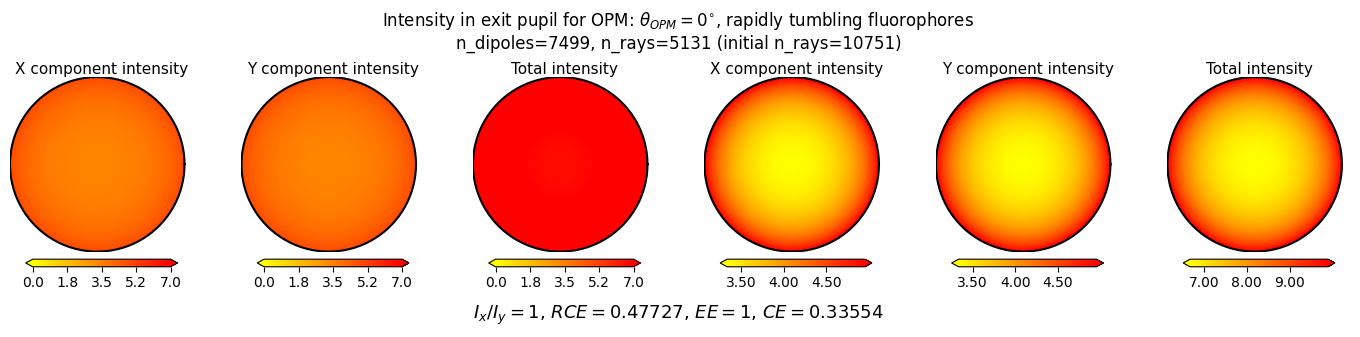

ray count 5131
max Ix 3.333547387795266
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.7399858967731551
max_r_reduced 0.7399781421125757 max_r 0.7399858967731551


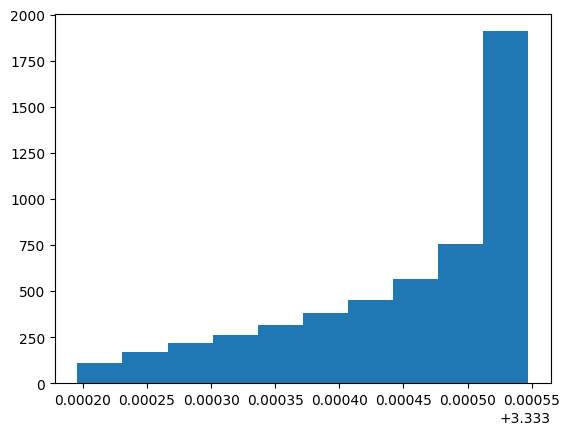

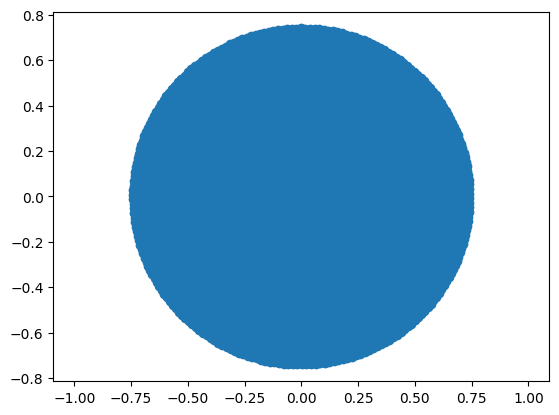

max_r_in None max_r 0.7399858967731551
cb3.vmax bf 6.6670945


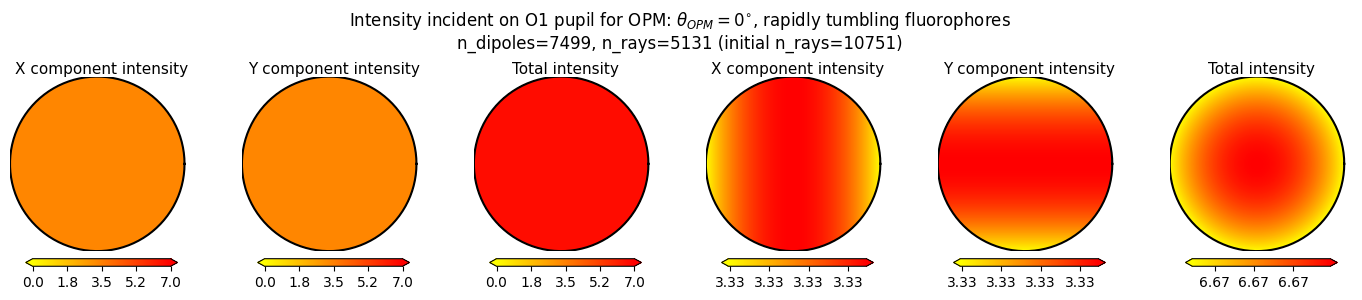

Full sphere generation
cap method area sum 12.564694874875116
expected area sum 6.283185307179586
plot exc arrow


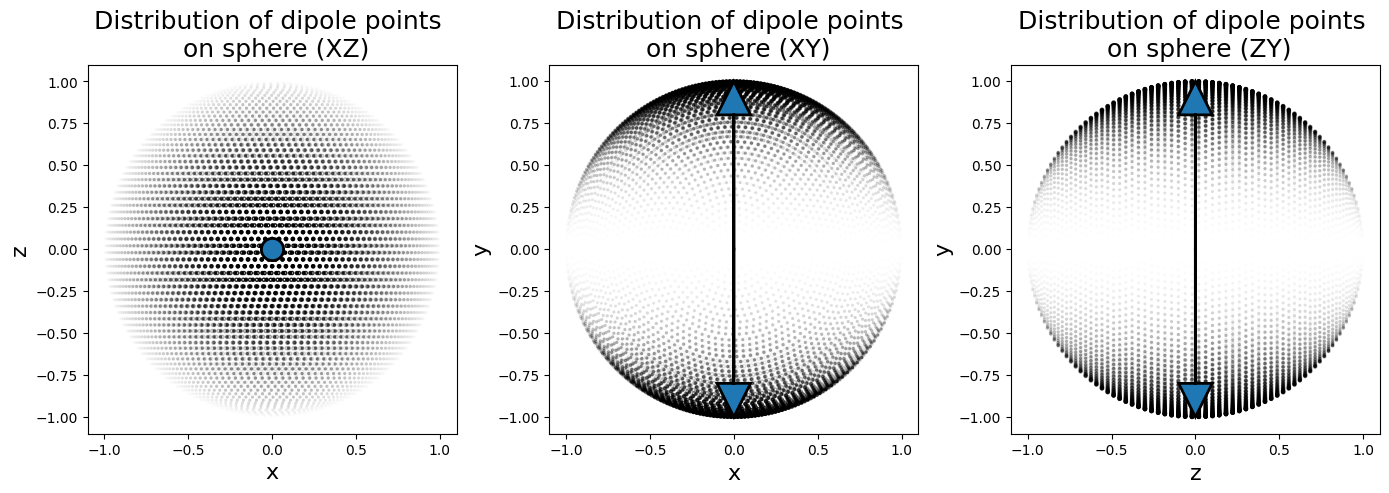

cap method area sum 4.417276005564659
expected area sum 4.4172760189146585


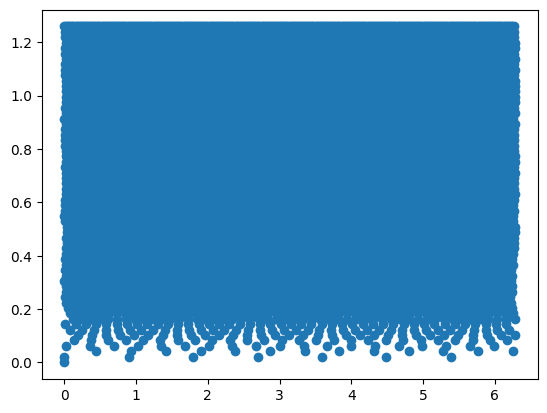

n_dipoles 7499
n_rays 10751
pvec shape (7499, 1, 3)
nvec shape (1, 10751, 3)
(7499, 10751, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
cap method area sum 6.283185293923816
expected area sum 6.283185307179586
n_dipoles 7499
n_rays 15308
pvec shape (7499, 1, 3)
nvec shape (1, 15308, 3)
(7499, 15308, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
n rays 2pi =  15308
(10751, 3, 1)
n rays =  10751
NA area vs real area? 4.417276005564659 4.4172760189146585
half_sphere_energy 1.3974071538438237
initial_energy 1.0200964685578027
rays when NA scaled up to hemisphere 15292.348758010825
initialisation time in system 31.980786s
Flat pupil
ELEMENT: <opmsim.optical_elements.SineLens object at 0x000002298D550820>
CURVED REFRACTION
max rho curved 0.003172725174692312
ELEMENT: <opmsim.optical_elements.SineLens object at 0x00000229E39214F0>
max rho flat 0.004219724482340775
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000022986CFD610>
CURVED REFRACTION
max rho curved 0.0
ELE

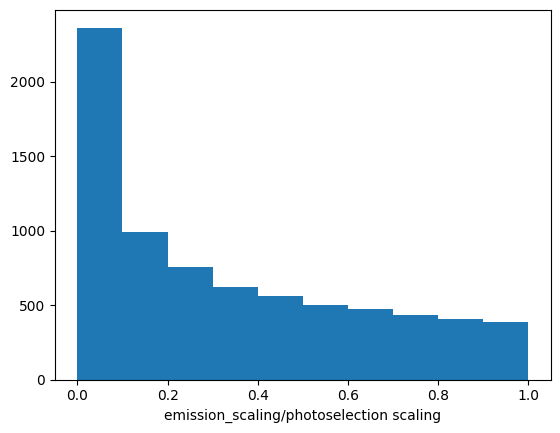

Limiting radius for detector: 0.004233333333333334
Energy ratio (efficiency): 0.5103948541484247
Total energy per dipole per ray: 0.5206519882868827
Energy from Ix 345.43357565793434
Energy from Iy 921.7567740102306
X/Y energy ratio = 0.37475566808701355
Half sphere energy 1.3974071538438237
Initial energy 1.0200964685578027
half sphere energy NA 0.9824209858410662
maxr 0.004233333333333334
5620 escaped out of 10751
Saved checkpoint with 10000 rays
5620 escaped out of 10751
time in trace_rays 64.754346s
ray count 5131
max Ix 1.044787876764912
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.0029599435864074482
max_r_reduced 0.002959912567765138 max_r 0.0029599435864074482


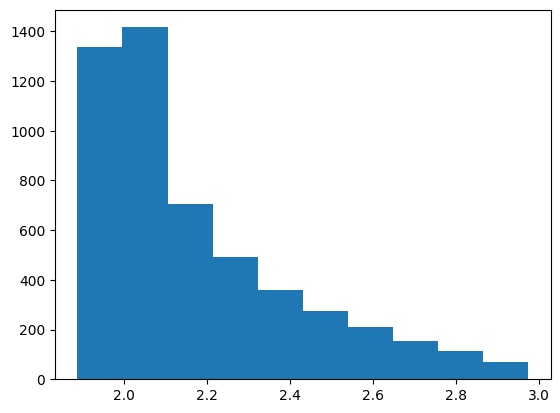

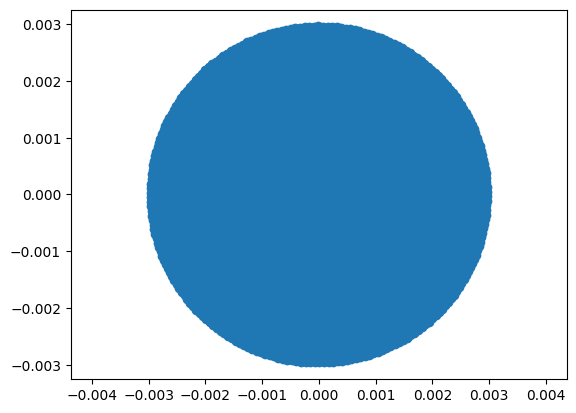

max_r_in None max_r 0.0029599435864074482
cb3.vmax bf 3.966


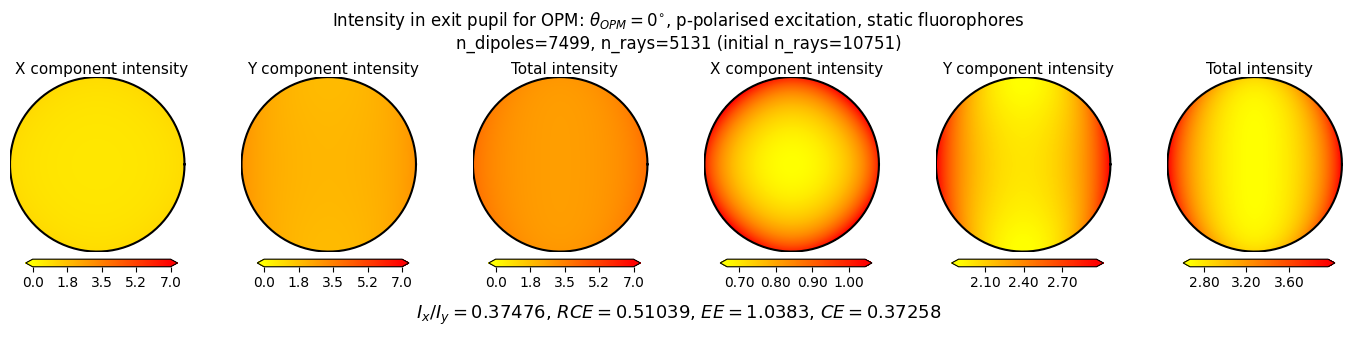

ray count 5131
max Ix 0.7027436923458984
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.7399858967731551
max_r_reduced 0.7399781421125757 max_r 0.7399858967731551


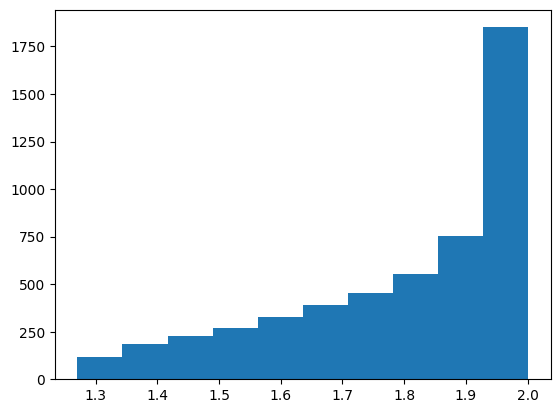

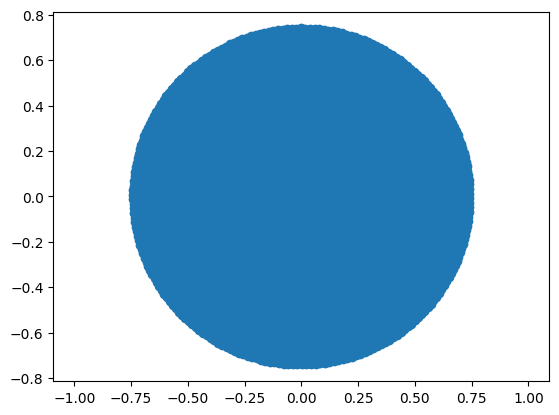

max_r_in None max_r 0.7399858967731551
cb3.vmax bf 2.667


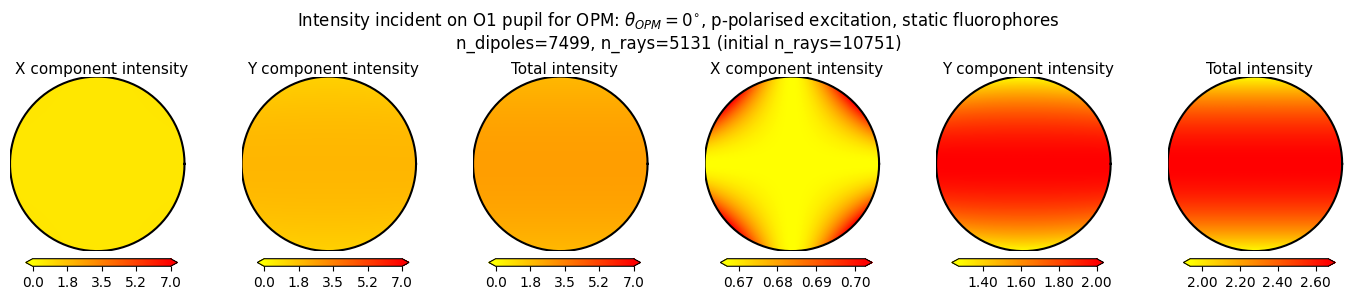

Full sphere generation
cap method area sum 12.564694874875116
expected area sum 6.283185307179586
plot exc arrow


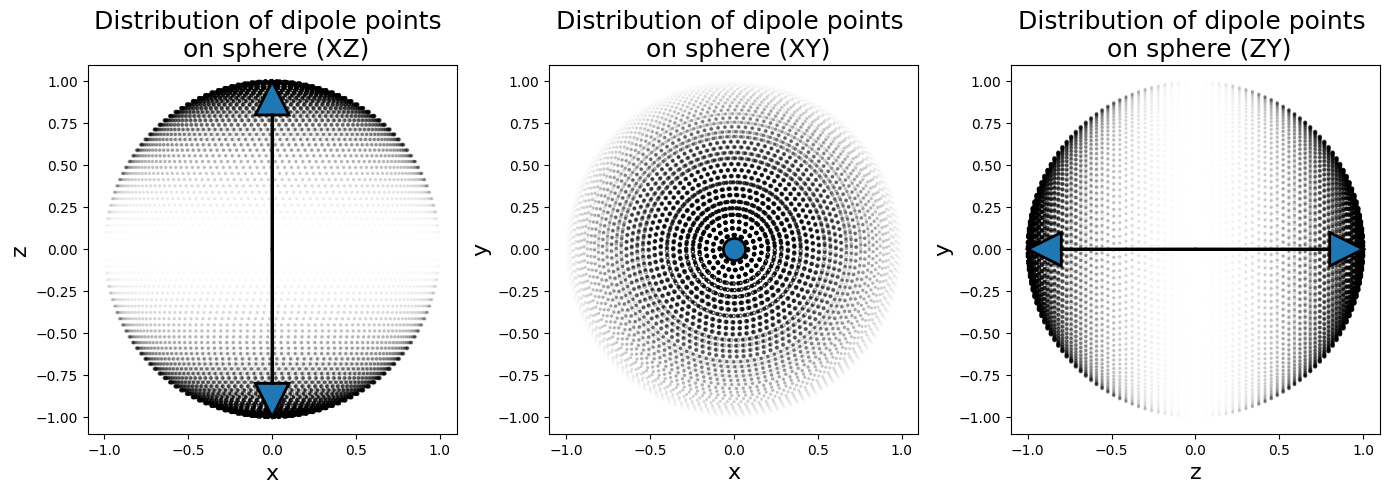

cap method area sum 4.417276005564659
expected area sum 4.4172760189146585


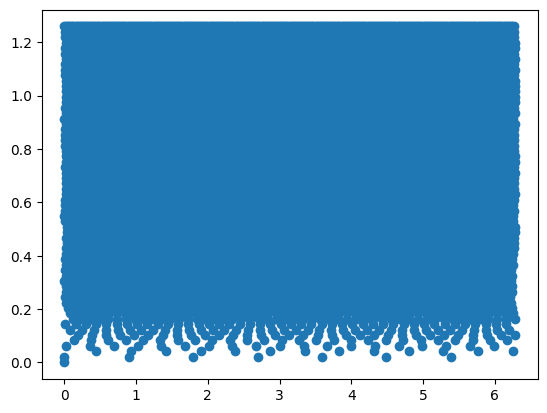

n_dipoles 7499
n_rays 10751
pvec shape (7499, 1, 3)
nvec shape (1, 10751, 3)
(7499, 10751, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
cap method area sum 6.283185293923816
expected area sum 6.283185307179586
n_dipoles 7499
n_rays 15308
pvec shape (7499, 1, 3)
nvec shape (1, 15308, 3)
(7499, 15308, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
n rays 2pi =  15308
(10751, 3, 1)
n rays =  10751
NA area vs real area? 4.417276005564659 4.4172760189146585
half_sphere_energy 1.3952001259464872
initial_energy 0.9055876783752907
rays when NA scaled up to hemisphere 15292.348758010825
initialisation time in system 31.748531s
Flat pupil
ELEMENT: <opmsim.optical_elements.SineLens object at 0x000002298D550820>
CURVED REFRACTION
max rho curved 0.003172725174692312
ELEMENT: <opmsim.optical_elements.SineLens object at 0x00000229E39214F0>
max rho flat 0.004219724482340775
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000022986CFD610>
CURVED REFRACTION
max rho curved 0.0
ELE

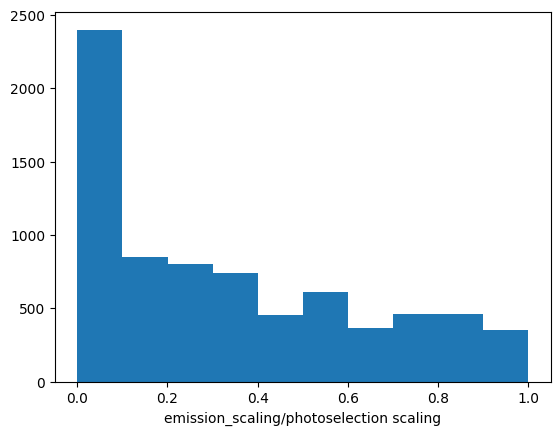

Limiting radius for detector: 0.004233333333333334
Energy ratio (efficiency): 0.4026725817554165
Total energy per dipole per ray: 0.36465532845727205
Energy from Ix 443.7587136626056
Energy from Iy 443.75871366260566
X/Y energy ratio = 0.9999999999999999
Half sphere energy 1.3952001259464872
Initial energy 0.9055876783752907
half sphere energy NA 0.9808693761210816
maxr 0.004233333333333334
5620 escaped out of 10751
Saved checkpoint with 10000 rays
5620 escaped out of 10751
time in trace_rays 65.215166s
ray count 5131
max Ix 2.0761178236979343
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.0029599435864074482
max_r_reduced 0.002959912567765138 max_r 0.0029599435864074482


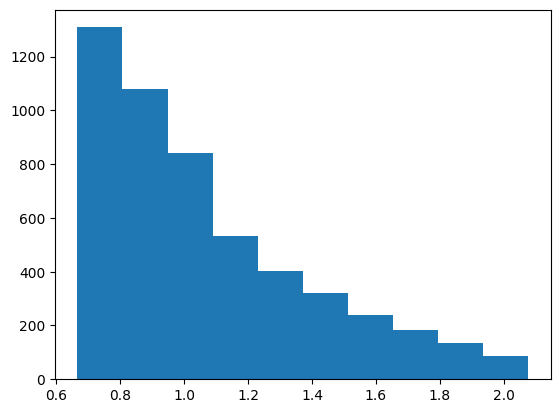

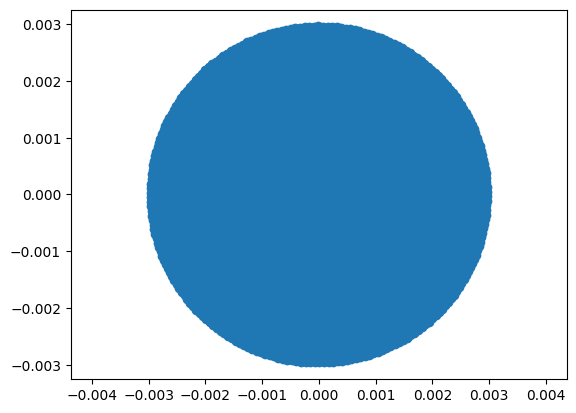

max_r_in None max_r 0.0029599435864074482
cb3.vmax bf 3.064


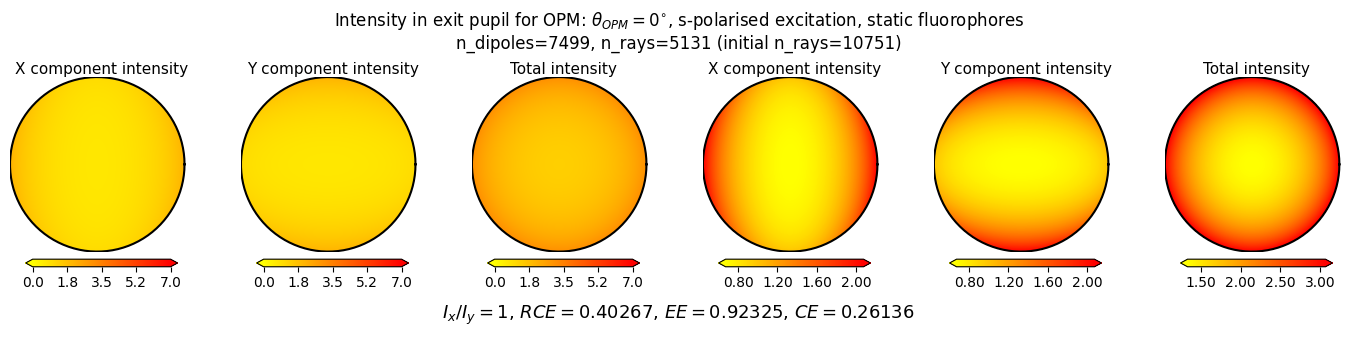

ray count 5131
max Ix 1.396435331627516
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.7399858967731551
max_r_reduced 0.7399781421125757 max_r 0.7399858967731551


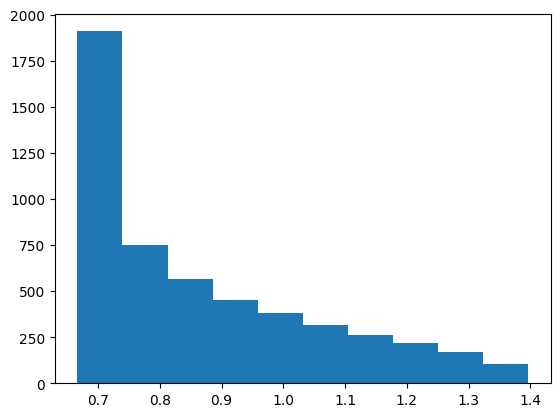

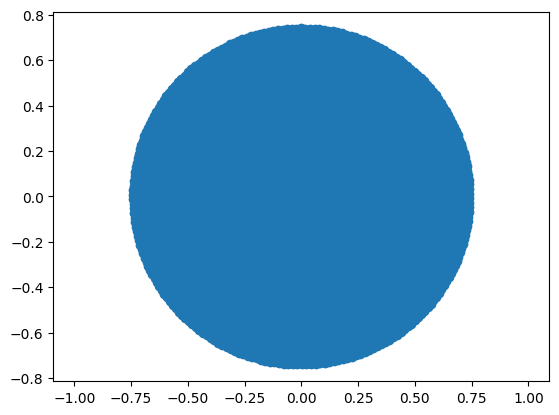

max_r_in None max_r 0.7399858967731551
cb3.vmax bf 2.061


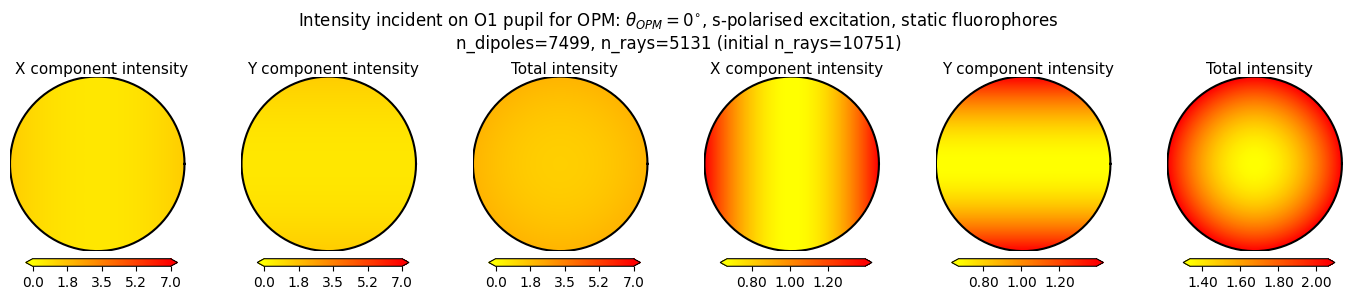

In [18]:
with open(save_details, 'a') as f:
    f.write("focal lengths:\n")
    f.write("O1,TL1,TL2,O2,O3\n")
    fs=[el.focal_length for el in elements_fun(0)]
    f.write(",".join(str(item) for item in fs))
    f.write("\noptions:\n")
    f.write(json.dumps(options))
    f.write("\nmin_OPM_angle: %f\n" % min_OPM_angle )
    f.write("\nOPM_angle_noclip: %f" % OPM_angle_noclip )
    
with open(save_filename, 'a') as f:
    f.write("angle,polarisation,NA1,NA2,NA3,RCE,EE,CE\n")
    for opm_angle in opm_angles:

        # un/depolarised
        source = dipole_source.DipoleSource()
        source.generate_dipoles(dipole_count)

        system = OpticalSystem("OPM (%d degrees) rapid tumbling" % opm_angle, elements_fun(opm_angle), source, options)
        system.trace()
        plot_options['title'] = \
            r'Intensity in exit pupil for OPM: $\theta_{OPM}=%d^{\circ}$, rapidly tumbling fluorophores' \
            % (opm_angle)
        pupil_fig = system.detector.plot_pupil(**plot_options_un)
        pupil_fig.savefig(os.path.join(savepath_full, "pupil_plot_tumbling_%d.png" % (opm_angle)), bbox_inches='tight' )

        f.write("%0.1f,%s, %.2f,%.2f,%.2f,%0.5f,%0.5f,%0.5f\n" % 
            (opm_angle, "unpolarised", elements_fun(opm_angle)[0].NA, elements_fun(opm_angle)[3].NA, elements_fun(opm_angle)[4].NA,
             system.detector.relative_collection_efficiency,
             system.detector.emission_efficiency, 
             system.detector.collection_efficiency)
            )

        plot_options['title'] = \
            r'Intensity incident on O1 pupil for OPM: $\theta_{OPM}=%d^{\circ}$, rapidly tumbling fluorophores'\
            % (opm_angle)
        pupil_fig_i = system.initial_detector.plot_pupil(**plot_options_un)
        pupil_fig_i.savefig(os.path.join(savepath_full, "initial_pupil_plot_tumbling_%d.png" % (opm_angle)), bbox_inches='tight' )

        # p-polarised 
        source = dipole_source.DipoleSource()
        source.generate_dipoles(dipole_count)
        source.classical_photoselection(p_pol)

        system = OpticalSystem("OPM system (%d degrees) p-polarised" % opm_angle, elements_fun(opm_angle), source, options)
        system.trace()
        plot_options['title'] = \
            r'Intensity in exit pupil for OPM: $\theta_{OPM}=%d^{\circ}$, p-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig = system.detector.plot_pupil(**plot_options_p)
        pupil_fig.savefig(os.path.join(savepath_full, "pupil_plot_p-polarised_%d.png" % (opm_angle)), bbox_inches='tight' )

        f.write("%0.1f,%s, %.2f,%.2f,%.2f,%0.5f,%0.5f,%0.5f\n" % 
            (opm_angle, "p-polarised", elements_fun(opm_angle)[0].NA, elements_fun(opm_angle)[3].NA, elements_fun(opm_angle)[4].NA,
             system.detector.relative_collection_efficiency,
             system.detector.emission_efficiency, 
             system.detector.collection_efficiency)
            )

        plot_options['title'] = \
            r'Intensity incident on O1 pupil for OPM: $\theta_{OPM}=%d^{\circ}$, p-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig_i = system.initial_detector.plot_pupil(**plot_options_p)
        pupil_fig_i.savefig(os.path.join(savepath_full, "initial_pupil_plot_p-polarised_%d.png" % (opm_angle)), bbox_inches='tight')

        # s-polarised
        source = dipole_source.DipoleSource()
        source.generate_dipoles(dipole_count)
        source.classical_photoselection(s_pol(opm_angle))

        system = OpticalSystem("OPM system (%d degrees) s-polarised" % opm_angle, elements_fun(opm_angle), source, options)
        system.trace()
        plot_options['title'] = \
            r'Intensity in exit pupil for OPM: $\theta_{OPM}=%d^{\circ}$, s-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig = system.detector.plot_pupil(**plot_options_s)
        pupil_fig.savefig(os.path.join(savepath_full, "pupil_plot_s-polarised_%d.png" % (opm_angle)), bbox_inches='tight' )

        f.write("%0.1f,%s, %.2f,%.2f,%.2f,%0.5f,%0.5f,%0.5f\n" % 
            (opm_angle, "s-polarised", elements_fun(opm_angle)[0].NA, elements_fun(opm_angle)[3].NA, elements_fun(opm_angle)[4].NA,
             system.detector.relative_collection_efficiency,
             system.detector.emission_efficiency, 
             system.detector.collection_efficiency)
            )

        plot_options['title'] = \
            r'Intensity incident on O1 pupil for OPM: $\theta_{OPM}=%d^{\circ}$, s-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig_i = system.initial_detector.plot_pupil(**plot_options_s)
        pupil_fig_i.savefig(os.path.join(savepath_full, "initial_pupil_plot_s-polarised_%d.png" % (opm_angle)), bbox_inches='tight' )



In [32]:
import json
fs=[el.focal_length for el in elements_fun(0)]
(",".join(str(item) for item in fs))


'0.003,0.18,0.162,0.0036,0.004'

In [5]:
opm_angles

[0, 35, 45, 25.54383661122486, 15.865785498045994]